In [3]:
from pathlib import Path
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import string
import scipy.constants
import scipy.special

#own modules
from evaluation.utils import db, tools
from evaluation.processing import tools_ec
from evaluation.visualization import plot

# specific functions for study
general_funcs = tools.import_from_path('general_funcs', r'../general_funcs.py')

def Gaussian(x,
            #a,
            tau,
            sigma,
            xc,
            deltax):
        """
        form matlab: a/2/tau.*(1-erf(sigma/sqrt(2)/tau-(x-xc)./sigma./sqrt(2))).*exp(sigma^2/2/tau^2-(x-xc)./tau)
        """
        # all parameters must be normalized by deltax to ensure normalized EMG --> integral = 1
        x = (x-(x.max()+x.min())/2)/deltax#  # x=0 of EMG must be in the middle of considered x range used for convolution 
        sigma = sigma/deltax
        xc = xc/deltax
        
        # gaussian
        return (1/sigma/np.sqrt(2*np.pi)
                *np.exp(-1/2*(x-xc)**2/sigma**2)
               )

def EMG(x,
        #a,
        tau,
        sigma,
        xc,
        deltax):
    """
    form matlab: a/2/tau.*(1-erf(sigma/sqrt(2)/tau-(x-xc)./sigma./sqrt(2))).*exp(sigma^2/2/tau^2-(x-xc)./tau)
    """
    # all parameters must be normalized by deltax to ensure normalized EMG --> integral = 1
    x = (x-(x.max()+x.min())/2)/deltax#  # x=0 of EMG must be in the middle of considered x range used for convolution 
    sigma = sigma/deltax
    xc = xc/deltax
    tau = tau/deltax

    # EMG exponentially modified gaussian
    return (1/2/tau
            *(1-scipy.special.erf(sigma/np.sqrt(2)/tau
                                  -(x-xc)/sigma/np.sqrt(2)))
            *np.exp(sigma**2/2/tau**2-(x-xc)/tau)
           )

def second_order_decay(x,
                       a,
                       b, 
                       s):
    return (a*1/(b*(x)+1)+s)

def first_order_decay(x,
                       a,
                       k, 
                       s):
    return (a*np.exp(-k*(x))+s)  # exponential model


def fit_second_order_decay_EMG(B, x,):
    if type(B) == str:
        if B == "label":
            return {
                "model": "fit_second_order_decay_EMG",  # used in legend and in result column name
                "formula": "",  # used in legend
                "beta0": ['a', 'b', 's', 'tau', 'sigma', 'xc', 'xmin', 'xmax', 'x_signal_min', 'x_signal_max'],
            }  # used in legend and in result column name
        elif (
            B == "curve_fit_model"
        ):  # use model('curve_fit_model', 0) when using scipy.optimize.curve_fit instead of scipy.odr
            return fit_second_order_decay_EMG_curve_fit

    a, b, s, tau, sigma, xc, xmin, xmax, x_signal_min, x_signal_max = B
    deltax = np.diff(x).mean()
    y_emg = EMG(x,
                tau,
                sigma,
                xc,
                deltax
               )

    y_signal = (np.where((x>x_signal_min) & (x<x_signal_max),1,0) 
                *second_order_decay(x-x_signal_min, 
                                           a,
                                           b, 
                                           s)
               )
    y_fit = np.convolve(a=y_signal,
                        v=y_emg,
                        mode='same')

    return y_fit

def fit_second_order_decay_EMG_curve_fit(x, *B):
    """
    Linear function to allow for compatibility of scipy.optimize.curve_fit and scipy.odr
    :param x: list, np.array, pd.Series
        x-data
    :param B: list
        list of parameters: [slope, y-axis intercept]
    :return: y-data
    """
    return fit_second_order_decay_EMG(B, x)

'done'

'done'

# Data

In [4]:
time_shift__s=0
overlay_cols =  ['id_sample', 'id_spot', 'icpms_location']
cols_ec_to_icpms=['loading__mg_Ir_cm2', 'ec_name_technique']

ec_x_col = 'Timestamp'+'_synchronized__s'




icpms_x_col_chosen = 't__timestamp_sfc_pc' 
icpms_x_col = icpms_x_col_chosen + '_synchronized__s'
time_correct_lengthML = False
time_shift = False

icpms_cols = {'plot':{
                      'y_col': 'dm_dt__pg_s',
                      'x_col': icpms_x_col,
                     },
               'fit':{
                      'y_col': 'dm_dt__pg_s',
                      'x_col': icpms_x_col,
                     },
              }
y_col_background = '_background'
y_col_background_corrected = '_background_corrected'
y_col_fit = icpms_cols['fit']['y_col']+'_fit'
icpms_cols['fit_result'] = {
                      'y_col': y_col_fit,
                      'y_col_background': y_col_fit+y_col_background,
                      'y_col_background_corrected': y_col_fit+y_col_background_corrected,
                      'y_col_fit_res': y_col_fit+'_res',
                     }


exp_ec, data_ec, exp_icpms, data_icpms, data_stability, \
        = db.get_exp_sfc_icpms(sql_ec='''SELECT *
                                         FROM exp_ec_expanded
                                         WHERE name_user = "n.roettcher"
                                             AND DATE(t_start__timestamp) IN ("2024-03-26","2024-04-03","2024-04-04")
                                             AND comment = 'act+SGEIS'
                                             AND name_setup_sfc_alias = "Sandwitch"
                                             #AND id_sample = 179 # equals loading__mg_Ir_cm2 > 1.6 but loading is added later
                                             AND id_ML_technique IN (2, 3, 4) # activation techniques # , 5
                                             ;''',
                                add_data_stability_analysis=True,  
                               add_gravimetric=True,
                              )
exp_ec.loc[exp_ec.fe_bottom_id_pump_out == 2, 'icpms_location'] = 'top'
exp_ec.loc[exp_ec.fe_bottom_id_pump_out == 3, 'icpms_location'] = 'bottom'



if type(cols_ec_to_icpms) != list:
    cols_ec_to_icpms = [cols_ec_to_icpms]

    

exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay  \
        = db.overlay_exp_sfc_icpms(exp_ec, data_ec, exp_icpms, data_icpms,
                                   overlay_cols=overlay_cols,
                                   cols_ec_to_icpms=cols_ec_to_icpms
                                  )

# additional synchronization for selected icpms time column
data_ec_overlay, data_icpms_overlay = plot.synchronize_timestamps(
            data_ec=data_ec_overlay,
            data_icpms=data_icpms_overlay,
            timestamp_col_ec="Timestamp",
            timestamp_col_icpms=icpms_x_col_chosen,
            overlay_index_cols=overlay_cols,
        )

if time_correct_lengthML:
    ## correct time sync for length of first technique (different for different MLs)
    first_exp_ec_technique = exp_ec_overlay.groupby(overlay_cols).first()
    time_diff_first_exp_ec_technique= first_exp_ec_technique.t_end__timestamp - first_exp_ec_technique.t_start__timestamp
    time_correct_exp_ec = time_diff_first_exp_ec_technique - time_diff_first_exp_ec_technique.min()
    time_correct_exp_ec.name='Timestamp_correction__timediff'
    data_ec_overlay.loc[:, ec_x_col] = data_ec_overlay.loc[:, ec_x_col] - data_ec_overlay.join(time_correct_exp_ec, ).Timestamp_correction__timediff.dt.seconds
    data_icpms_overlay.loc[:, icpms_x_col] = data_icpms_overlay.loc[:, icpms_x_col] - data_icpms_overlay.join(time_correct_exp_ec, ).Timestamp_correction__timediff.dt.seconds

## add colums
data_icpms_overlay.loc[:, 'dm_dt__pg_s'] = data_icpms_overlay.dm_dt__ng_s *1000
data_icpms_overlay.loc[:, 'dm_dt__g_s'] = data_icpms_overlay.dm_dt__ng_s * 1e-9
data_icpms_overlay.loc[:, 'is_during_ocp'] = data_icpms_overlay.id_exp_sfc.isin(exp_ec.loc[exp_ec.ec_name_technique == 'exp_ec_ocp', :].index)

if time_shift:
    def avg_timeshift(exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay, time_shift__s=time_shift__s):
        # shifting top timestamp - assuming too late rise in counts due to diffusion broadening during delay time
        # shift time of top measurement
        # remove all data points below 0s (averaging and calculation of ratio will be performed on number of data points assuming time is synced so ignoring actual timestamp)
        data_icpms_overlay.loc[data_icpms_overlay.index.get_level_values(level='icpms_location') == 'top', 
                               icpms_x_col] \
            = data_icpms_overlay.loc[data_icpms_overlay.index.get_level_values(level='icpms_location') == 'top', 
                                        icpms_x_col] + time_shift__s

        return data_icpms_overlay

    data_icpms_overlay = avg_timeshift(exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay, time_shift__s=time_shift__s)



######
# Baseline correction for Iridium 
####    
for key in ['plot', 'fit']:
    data_icpms_overlay, icpms_y_col_background, icpms_y_col_background_corrected\
                    = general_funcs.background_correction(icpms_x_col=icpms_x_col,
                          icpms_y_col=icpms_cols[key]['y_col'],
                          data_icpms_overlay=data_icpms_overlay,
                          y_col_background=y_col_background,
                          y_col_background_corrected=y_col_background_corrected,
                          )
    icpms_cols[key]['y_col_background'] = icpms_y_col_background
    icpms_cols[key]['y_col_background_corrected'] = icpms_y_col_background_corrected
### baseline correction finished





Link selected experiments to PublicationExport:  HTE09_hCCM_setup
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 24 
SELECT id_exp_sfc, t_start__timestamp,t_end__timestamp, id_exp_icpms, spots_spot_size__mm2, fc_top_name_flow_cell_A_opening_ideal__mm2, fc_top_name_flow_cell_A_opening_real__mm2, fc_top_id_sealing_A_opening__mm2, fc_top_id_PTL_A_PTL__mm2, fc_bottom_name_flow_cell_A_opening_ideal__mm2, fc_bottom_name_flow_cell_A_opening_real__mm2, fc_bottom_id_sealing_A_opening__mm2, fc_bottom_id_PTL_A_PTL__mm2  FROM match_exp_sfc_exp_icpms m   
           WHERE (id_exp_sfc)   IN (12858, 12859, 12860, 12938, 12939, 12940, 13035, 13036, 13037, 13149, 13150, 13151, 13208, 13209, 13210, 13281, 13282, 13283, 13352, 13353, 13354, 13410, 13411, 13412);
Read data from "exp_icpms_sfc_expanded" ...
SELECT * FROM exp_icpms_sfc_expanded WHERE (`id_exp_icpms`) IN (709, 724, 737);
Done in  0:00:00.021547
Link selected experiments to PublicationExport:  HTE09_hCCM_se

/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/processing/tools_ec.py:964: UserWarning: Column: "j__mA_cm2geo_active_chosen" not available in data_ec. Will be skipped.
  warnings.warn(f'Column: "{col}" not available in data_ec. Will be skipped.')


SELECT id_exp_sfc, t_start__timestamp,t_end__timestamp, id_exp_icpms, spots_spot_size__mm2  FROM match_exp_sfc_exp_icpms m   
           WHERE (id_exp_sfc)   IN (12858, 12859, 12860, 12938, 12939, 12940, 13035, 13036, 13037, 13149, 13150, 13151, 13208, 13209, 13210, 13281, 13282, 13283, 13352, 13353, 13354, 13410, 13411, 13412);
Added snychronized timestamp column:  Timestamp_synchronized__s
Added snychronized timestamp column:  t_delaycorrected__timestamp_sfc_pc_synchronized__s
Added snychronized timestamp column:  Timestamp_synchronized__s
Added snychronized timestamp column:  t__timestamp_sfc_pc_synchronized__s
Already corrected, it is nor recalculated


# Data export for matlab

In [3]:

exp_icpms_overlay_selected = exp_icpms_overlay.loc[lambda row: ((row.index.get_level_values('name_isotope_analyte')=='Ir193') 
                                   & (row.index.get_level_values('id_sample')==179))].copy()
exp_icpms_overlay_selected_modelling = exp_icpms_overlay_selected.loc[:, ['loading__mg_Ir_cm2']]\
                                                                    .assign(a=np.nan,
                                                                            b=np.nan,
                                                                            s=np.nan,
                                                                            tau=np.nan,
                                                                            sigma=np.nan,
                                                                            xc=np.nan,
                                                                           )\
                                                                .drop(columns=['loading__mg_Ir_cm2'])


for index, row in exp_icpms_overlay_selected.iterrows():
    print('data_icpms_'+'_'.join([str(val) for val in index])+'.csv')
    exp_ec_overlay_selected = exp_ec_overlay.loc[index[:-3]]
    data_ec_overlay_selected = data_ec_overlay.loc[index[:-3]]

    data_icpms_overlay_selected_modelling_single = data_icpms_overlay.loc[index,['t__timestamp_sfc_pc_synchronized__s', 'dm_dt__pg_s_background_corrected']]
    exp_icpms_overlay_selected_modelling.loc[index, 'xmin'] = data_icpms_overlay_selected_modelling_single.t__timestamp_sfc_pc_synchronized__s.iloc[0]
    exp_icpms_overlay_selected_modelling.loc[index, 'xmax'] = data_icpms_overlay_selected_modelling_single.t__timestamp_sfc_pc_synchronized__s.iloc[-1]
    exp_icpms_overlay_selected_modelling.loc[index, 'x_signal_min'] = data_ec_overlay_selected.loc[(exp_ec_overlay_selected.loc[lambda row: row.ec_name_technique == 'exp_ec_ghold'].index.values[0], ), ec_x_col].iloc[0]
    exp_icpms_overlay_selected_modelling.loc[index, 'x_signal_max'] = data_ec_overlay_selected.loc[(exp_ec_overlay_selected.loc[lambda row: row.ec_name_technique == 'exp_ec_ghold'].index.values[0], ), ec_x_col].iloc[-1]
    data_icpms_overlay_selected_modelling_single.to_csv('data_icpms_'+'_'.join([str(val) for val in index])+'.csv')
exp_icpms_overlay_selected_modelling.to_csv('exp_icpms_fit_params.csv')
exp_icpms_overlay_selected_modelling 


data_icpms_179_5_bottom_737_Ir193_Re187.csv
data_icpms_179_7_top_709_Ir193_Re187.csv
data_icpms_179_8_top_709_Ir193_Re187.csv
data_icpms_179_10_bottom_737_Ir193_Re187.csv


a  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard       
179       5       bottom         737          Ir193                Re187                         NaN   
          7       top            709          Ir193                Re187                         NaN   
          8       top            709          Ir193                Re187                         NaN   
          10      bottom         737          Ir193                Re187                         NaN   

                                                                                                   b  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard       
179       5       bottom         737          Ir193                Re187                         NaN   
          7       top            709          Ir193                Re187                         NaN   
          8       top            709          Ir193                Re187                         NaN   
          10      bottom         737          Ir193                Re187                         NaN   

                                                                                                   s  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard       
179       5       bottom         737          Ir193                Re187                         NaN   
          7       top            709          Ir193                Re187                         NaN   
          8       top            709          Ir193                Re187                         NaN   
          10      bottom         737          Ir193                Re187                         NaN   

                                                                                                  tau  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard        
179       5       bottom         737          Ir193                Re187                          NaN   
          7       top            709          Ir193                Re187                          NaN   
          8       top            709          Ir193                Re187                          NaN   
          10      bottom         737          Ir193                Re187                          NaN   

                                                                                                  sigma  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard          
179       5       bottom         737          Ir193                Re187                            NaN   
          7       top            709          Ir193                Re187                            NaN   
          8       top            709          Ir193                Re187                            NaN   
          10      bottom         737          Ir193                Re187                            NaN   

                                                                                                  xc  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard       
179       5       bottom         737          Ir193                Re187                         NaN   
          7       top            709          Ir193                Re187                         NaN   
          8       top            709          Ir193                Re187                         NaN   
          10      bottom         737          Ir193                Re187                         NaN   

                                                                                                    xmin  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard           
179       5       bottom         737          Ir193                Re187                          13.057   
 

# sfig:dis_pro_modelling

/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:2405: UserWarning: For index: (179, 5, 'bottom', 737, 'Ir193', 'Re187') only NaNs found in data table. Will be skipped and not plotted. Label Model will not be added to legend.
  warnings.warn(
/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:2405: UserWarning: For index: (179, 5, 'bottom', 737, 'Ir193', 'Re187') only NaNs found in data table. Will be skipped and not plotted. Label Model residuals will not be added to legend.
  warnings.warn(


 Plot  sfig_top_bottom_modelling.pdf  successfully saved 
![[Binder_export/Figures/Fig_S4/sfig_top_bottom_modelling.pdf]] <br> *jupyter notebook source:* ![[Binder_export/Figures/Fig_S4/$$dummy_replaced_by_obsidian_jupyter$$]]


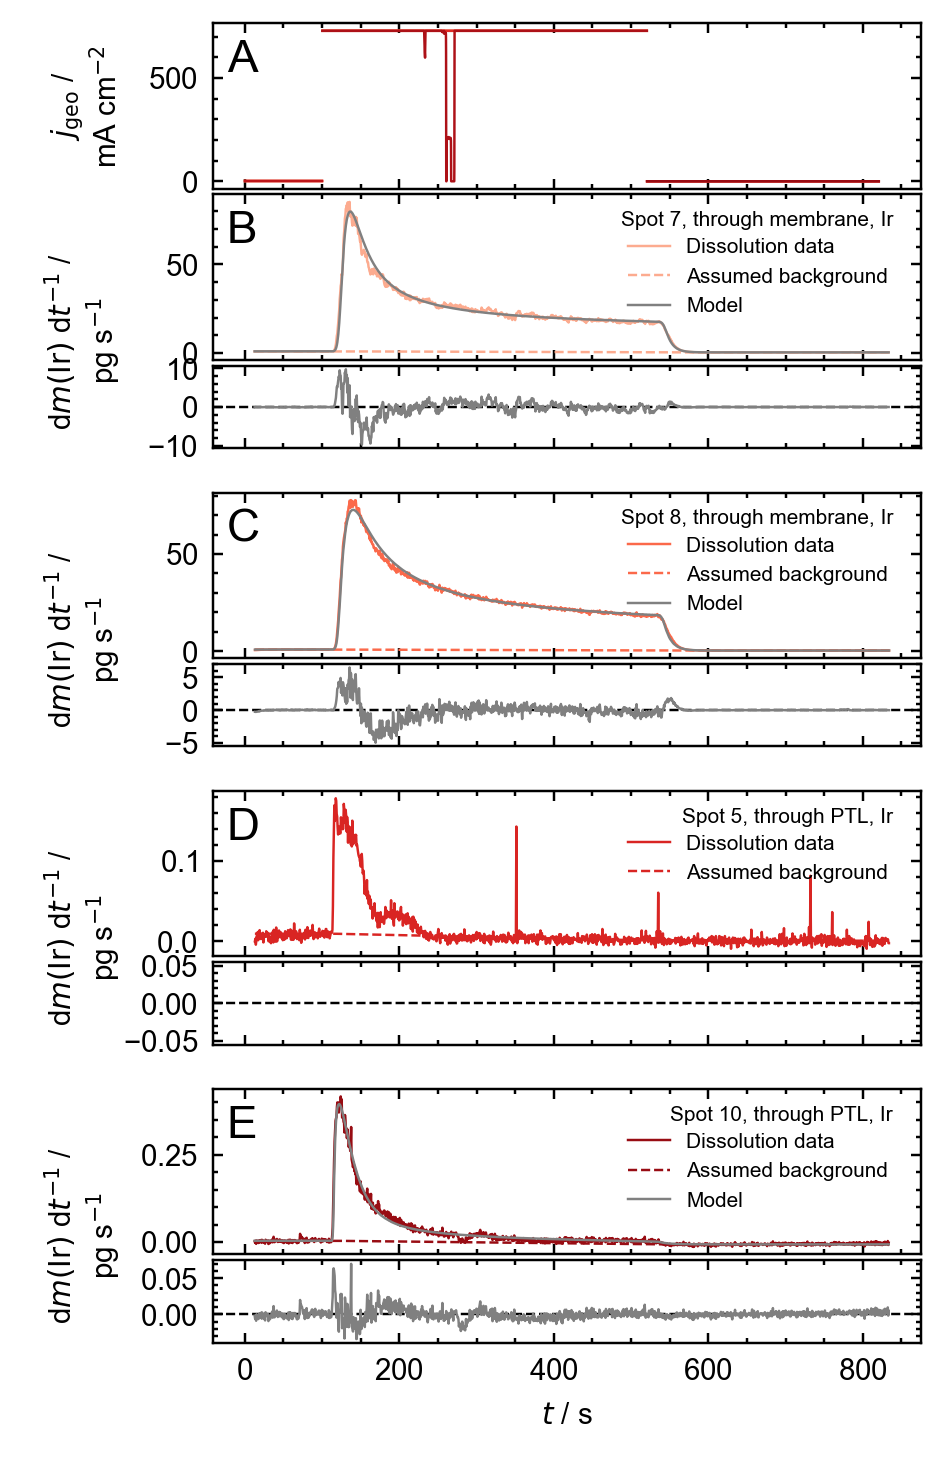

In [5]:
ec_y_col='j__mA_cm2geo_fc_bottom_PTL'

# get fit with specifications:
method='matlab'
weight='weighted'
ids_sample=[179] # 180, 181
names_isotope_analyte=['Ir193'] # 'Ti47'
ids_spot=[7,8,10] 
df_fit_values_file = 'matlab_fitting_results.csv'

plot.manual_col_to_axis_label['dm_dt__pg_s'] = 'd$m(\mathrm{Ir})$ d$t^{-1}$ /\npg s$^{-1}$' 
plot.manual_col_to_axis_label['dm_dt__pg_s_background_corrected'] = 'd$m(\mathrm{Ir})$ d$t^{-1}$ (backgr. corr.) / pg s$^{-1}$' 
plot.manual_col_to_axis_label['dm_dt__g_s_background_corrected'] = 'd$m(\mathrm{Ir})$ d$t^{-1}$ (backgr. corr.) / g s$^{-1}$' 
plot.manual_col_to_axis_label['dm_dt_S__ng_s_cm2geo_fc_bottom_PTL'] = 'd$m$ d$t^{-1}$ $S^{-1}$ /\nng s$^{-1}$ cm$^{-2}$'
plot.manual_col_to_axis_label['j__mA_cm2geo_fc_bottom_PTL'] = '$j_\\mathrm{geo}$ /\nmA cm$^{-2}$'

exp_icpms_overlay_selected = exp_icpms_overlay.loc[lambda row: ((row.index.get_level_values('name_isotope_analyte').isin(names_isotope_analyte))
                                                          &(row.index.get_level_values('id_sample').isin(ids_sample)))]\
                                        .sort_values(by=['name_isotope_analyte','icpms_location'], ascending=[True, False])\
                                        .copy()
exp_ec_overlay_selected = exp_ec_overlay.loc[lambda row: row.index.get_level_values('id_sample').isin(ids_sample)].copy()


df_fit_values = pd.read_csv(df_fit_values_file, index_col=['id_sample', 'id_spot',  'name_isotope_analyte', 'weight', 'method'#, 'fixed_vals'
                                                                  ])
df_fit_values_chosen = df_fit_values.loc[lambda row: ((row.index.get_level_values('id_sample').isin(ids_sample))
                                                      &(row.index.get_level_values('name_isotope_analyte').isin(names_isotope_analyte))
                                                      &(row.index.get_level_values('id_spot').isin(ids_spot))
                                                      &(row.index.get_level_values('method')==method)
                                                      &(row.index.get_level_values('weight')==weight)
                              )].copy()
exp_icpms_overlay_selected2 = exp_icpms_overlay_selected.join(df_fit_values_chosen.reset_index().set_index(['id_sample', 'id_spot', 'name_isotope_analyte']),
                          on=['id_sample', 'id_spot', 'name_isotope_analyte']).copy()

for index, row in exp_icpms_overlay_selected2.iterrows():
    data_icpms_overlay.loc[index, icpms_cols['fit_result']['y_col_background_corrected']] = fit_second_order_decay_EMG([row.a,
                                                                                  row.b,
                                                                                  row.s,
                                                                                                                        row.tau,
                                                                                  row.sigma,
                                                                                  row.xc,
                                                                                  row.xmin,
                                                                                  row.xmax,
                                                                                  row.x_signal_min,
                                                                                  row.x_signal_max,
                                                                                    ],
                                                                                data_icpms_overlay.loc[index, icpms_x_col]
                                                                                )
data_icpms_overlay.loc[:, icpms_cols['fit_result']['y_col']]  = data_icpms_overlay.loc[:, icpms_cols['fit_result']['y_col_background_corrected']] + data_icpms_overlay.loc[:, icpms_cols['fit']['y_col_background']]
data_icpms_overlay.loc[:, icpms_cols['fit_result']['y_col_fit_res']]  = data_icpms_overlay.loc[:, icpms_cols['fit']['y_col_background_corrected']] - data_icpms_overlay.loc[:, icpms_cols['fit_result']['y_col_background_corrected']]


with plt.rc_context(plot.get_style(style='singleColumn',
                                  increase_fig_height=2.5,
                                   add_margins= {'left': 0.8,},
                                   add_margins_between_subplots={'hspace':0.5},
                                  interactive =True,)):
    plot_storage = plot.PlotDataStorage('sfig_top_bottom_modelling', overwrite_existing=True)

    fig = plt.figure()
    
    height_ratios = [1,] + [1, 0.5, 0.2]*len(exp_icpms_overlay_selected.index)
    gs = gridspec.GridSpec(len(height_ratios), 
                           1, 
                           height_ratios=height_ratios,
                          )
    ax1 = fig.add_subplot(gs[0, 0])
    axs = [ax1, ]
    axs_pairs=[]
    gs_idx = 1
    
    exp_icpms_overlay_selected = exp_icpms_overlay_selected\
                .dataset\
                    .add_column('icpms_location_label',
                             values=['membrane',
                                     'PTL',
                                    ],
                            rowindexers=[exp_icpms_overlay_selected.index.get_level_values('icpms_location')=='top',
                                         exp_icpms_overlay_selected.index.get_level_values('icpms_location')=='bottom',
                                        ],
                                    )\
                .add_column('plot_label', 
                             values='Spot '+exp_icpms_overlay_selected.index.get_level_values('id_spot').astype(str)+', through '+exp_icpms_overlay_selected.icpms_location_label+', '+exp_icpms_overlay_selected.index.get_level_values('name_isotope_analyte').astype(str).str.strip('1234567890'),
                                    )\
                .return_dataset()
    
    for index, row in exp_icpms_overlay_selected.iterrows():
        #print(row)
        gs_idx_init = gs_idx
        ax_fit = fig.add_subplot(gs[gs_idx, 0], sharex=ax1)
        gs_idx += 1
        ax_fitres = fig.add_subplot(gs[gs_idx, 0], sharex=ax1)
        gs_idx += 1
        ax_combi = plot.add_empty_subplot(fig, gs[gs_idx_init:gs_idx+1, 0])
        gs_idx += 1 # for extra space after res plot
        
        
        
        axs_pairs += [[ax_fit, ax_fitres, ax_combi]]
        axs += [ax_fit, ax_fitres]
        
        # Plot labels
        ax_fit.text(0.96, 0.9, 
                        row.plot_label, 
                        transform=ax_fit.transAxes, 
                        ha='right',
                        va='top',
                    fontsize=5,
                   )
        
        
        exp_icpms_overlay_selected.loc[index, 'ax_col_fit'] = ax_fit
        exp_icpms_overlay_selected.loc[index, 'ax_col_fitres'] = ax_fitres

    #Hide xaxis label on ax
    [ax.tick_params(axis='x', which='both', labelbottom=False) for ax in axs[:-1]]


    
    exp_ec_overlay_selected = exp_ec_overlay_selected\
                    .dataset\
            .add_column('color', 
                                     values='Reds',  cmap_min=0.3, cmap_max=0.9,
                                    )\
                    .add_column('label', 
                                 values=exp_ec_overlay_selected.loading__mg_Ir_cm2.apply(lambda x: '{0:.1f}'.format(x)).astype(str)+' mg$_{\mathrm{Ir}}$ cm$^{-2}$',
                                rowindexer_first_of_group='id_sample', 
                                )\
                    .plot(x_col=ec_x_col,
                         y_col=ec_y_col,
                          ax=ax1,
                         data=data_ec_overlay,   
                    ) \
    .return_dataset()
    
    """
                        .plot(x_col='Timestamp_synchronized_corrected__s',
                         y_col='E_WE_uncompensated__VvsRHE',
                          ax=ax2,
                         data=data_ec_overlay_selected,   
                    )\
    """
    

    exp_icpms_overlay_selected = exp_icpms_overlay_selected\
                    .dataset\
                    .add_column('color', 
                                 values='Reds',  cmap_min=0.3, cmap_max=0.9,
                                )\
                    .plot(x_col=icpms_x_col,
                          y_col=icpms_cols['plot']['y_col'],
                          ax='ax_col_fit',
                          data=data_icpms_overlay,  
                          label='Dissolution data',
                    )\
                    .plot(x_col=icpms_x_col,
                          y_col=icpms_cols['plot']['y_col_background'],
                          ax='ax_col_fit',
                          data=data_icpms_overlay,  
                          linestyle='--',
                          axlabel_auto=False,
                          label='Assumed background',
                    )\
                    .plot(x_col=icpms_x_col,
                          y_col=icpms_cols['fit_result']['y_col'],
                          ax='ax_col_fit',
                          data=data_icpms_overlay,
                          color='gray',
                          axlabel_auto=False,
                          label='Model',
                    )\
                    .plot(x_col=icpms_x_col,
                          y_col=icpms_cols['fit_result']['y_col_fit_res'],
                          ax='ax_col_fitres',
                          data=data_icpms_overlay, 
                          color='gray',
                          axlabel_auto=False,
                          label='Model residuals',
                    )\
                    .return_dataset()


    axs_label = [ax1,] + [ax_fit for ax_fit, ax_fitres, ax_combi in axs_pairs]
    plot_labels = list(string.ascii_uppercase)[:len(axs_label)]
    for ax, plot_label in zip(axs_label, plot_labels):
        ax.text(0.02, 0.9, plot_label, 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=11)
    
    for ax_fit, ax_fitres, ax_combi in axs_pairs:
        legend=ax_fit.legend(loc='upper right',
                      bbox_to_anchor=(0.98, 0.85),
                      fontsize=5,
                     )
        legend.get_frame().set_alpha(0) # alpha to invisible
        
        xlims = ax_fitres.get_xlim()
        ax_fitres.hlines(0,
                      xmin=xlims[0],
                      xmax=xlims[1],
                      linestyle='--',
                      zorder=-1,
                      color='black'
                     )
        ax_fitres.set_xlim(xlims)
        ax_combi.set_ylabel(ax_fit.get_ylabel())
        ax_fit.set_ylabel('')

    for ax in axs[:-1]:
        ax.set_xlabel('')
        plt.setp(ax.get_xticklabels(), visible=False)
    axs[-1].set_xlabel('$t$ / s')
    
    fig.align_ylabels([ax1,]+   sum([[ax_fit, ax_combi] for ax_fit, ax_fitres, ax_combi in axs_pairs], []))

    plot_storage.export(fig, plot_format='pdf')
    plt.show()


In [7]:
exp = pd.read_csv('matlab_fitting_results.csv',index_col=['icpms_location', 'id_spot'])
print(exp.sort_values(by='icpms_location').loc[:, ['a', 'b', 's', 'tau', 'sigma', 'xc']].to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &    &            a &            b &             s &        tau &     sigma &         xc \\
icpms\_location & id\_spot &              &              &               &            &           &            \\
\midrule
bottom & 5  &  3518.238458 &  6722.699718 &  8.160000e-13 &  23.329315 &  0.521416 &  14.075635 \\
    & 10 &     5.687508 &     1.779515 &  2.220000e-14 &  13.124812 &  0.847608 &  13.686808 \\
top & 7  &   143.110049 &     0.084541 &  1.327755e+01 &   8.083011 &  3.088099 &  21.521854 \\
    & 8  &    95.930706 &     0.029188 &  1.072394e+01 &   8.810532 &  2.542704 &  19.832178 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1217102/2820379264.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(exp.sort_values(by='icpms_location').loc[:, ['a', 'b', 's', 'tau', 'sigma', 'xc']].to_latex())
